In [1]:
import torch

In [2]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words  = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items() }
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
block_size = 3
X,Y = [],[]
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:]+ [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [8]:
C = torch.randn((27, 2))


In [9]:
emb = C[X]

In [10]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [11]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # -1 identifies the underlying size aka 32, 64 etc of the tensor

In [12]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [13]:
logits = h @ W2 + b2

In [14]:
logits.shape

torch.Size([228146, 27])

In [15]:
counts = logits.exp()

In [16]:
prob = counts/counts.sum(1, keepdims = True )

In [17]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [28]:
def build_dataset(words):
    block_size = (
        3  # context length: how many characters do we take to predict the next one?
    )
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), ' --- >', itos[ix])
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [78]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [79]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch. randn((27, 10), generator=g)
W1 = torch.randn((30, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [80]:
sum(p.nelement() for p in parameters)

17697

In [81]:
for p in parameters:
    p.requires_grad = True

In [82]:
lre = torch.linspace(-3,0,1000)
lrs = 10 ** lre

In [83]:
lri = []
lossi = []
stepi = []

In [92]:


for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters:
        p.grad = None
        
    loss.backward()
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

1.9795143604278564


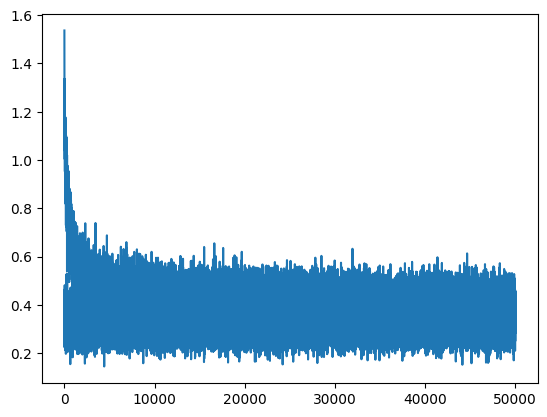

In [93]:
plt.plot(stepi, lossi)

In [94]:
emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1810, grad_fn=<NllLossBackward0>)

In [95]:
emb = C[Xdev]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2180, grad_fn=<NllLossBackward0>)

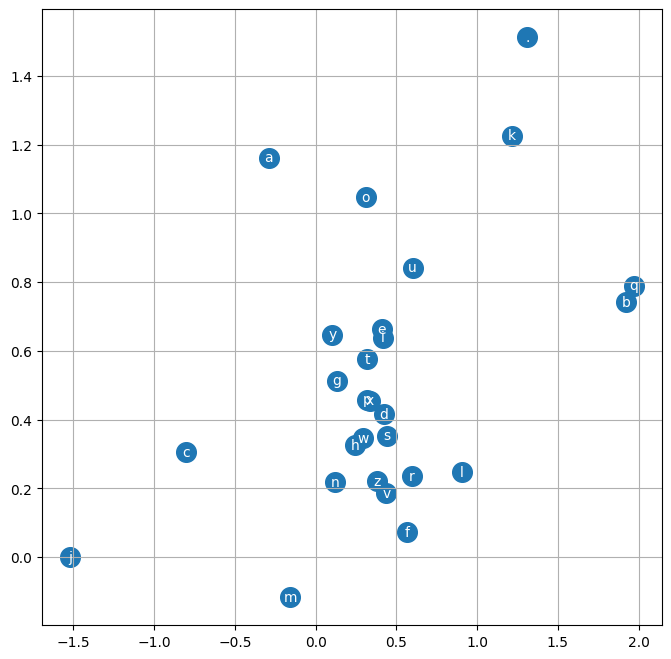

In [96]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [102]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h= torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context [1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mora.
mayanniee.
mad.
rylla.
emmadiendrari.
adeerdieliah.
milopaleigh.
estanaraelyn.
malquann.
shurergahshie.
trickentleigh.
teusan.
bented.
ruyah.
faeha.
kaesh.
sakyda.
hal.
calynn.
una.
